# Exploring cross-domain text semantic similarity using large language models

## Method: scraped short, medium, long texts(news articles) online
Each dataset consists of 35 news articles across 7 domains: Sports, Finance, Politics, Beauty, Medicine, Arts, and Science.  

1. Short Texts: 40-80 words  
2. Medium Texts: 120-250 words  
3. Long Texts: 300-400+ words  


In [1]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from nltools.stats import _calc_pvalue, correlation, fisher_r_to_z, matrix_permutation
import scipy.stats as stats
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# Using OpenAI ada002 text embedding model

In [8]:
import openai
openai.api_key = 'your_api_key'
def get_embedding(text: str, model="text-embedding-ada-002") -> list[float]:
    return openai.Embedding.create(input=[text], model=model)["data"][0]["embedding"]


embedding = get_embedding("I hate you", model="text-embedding-ada-002")
len(embedding)

1536

## short news -> 40-80 words

In [2]:
# read txt
f = open('./data/news_short.txt', 'r', encoding='utf-8')
lines = f.readlines()
print(lines)
# 將新聞頭條和對應的類別名稱分別存成兩個list
headlines = [line.strip() for line in lines]
categories = ['體育']*5 + ['金融']*5 + ['政治']*5 + ['美妝']*5 + ['醫學']*5 + ['藝術']*5 + ['科學']*5

# 將兩個list轉換為dataframe
df = pd.DataFrame({'headlines': headlines, 'category': categories})

f.close()
# 印出dataframe
print(df)

['奧運像是競技場上四年施放一次的璀璨煙火，台灣選手在今年繳出最佳成績，確實值得高興喝采。但激情過後，我們如何延續熱情才是重點。\n', '回想一下，從小到大的體育課是什麼樣貌呢？ 是常常被借去考試？還是幾乎等於自由活動時間？又或是每堂課都非常扎實，讓你有機會認識各項運動？\n', '作為金州勇士籃球球迷，見證了過去幾年舊金山浪花兄弟起伏、恍若淘金熱時的興衰變化。\n', '大聯盟新時代來臨！無論是在小聯盟多年的磨練、或是早已在國外揚名立萬的棒球員們都有個共同的目標，就是挑戰夢寐以求的大聯盟戰場。\n', '四年一度的世界盃足球賽終於在卡達風光落幕，最終由梅西所領軍的阿根廷奪冠，上演一場有史以來最激烈的冠軍戰。\n', '商用地產債務危機正在醞釀，知名全球地產商三個月內兩度債務違約，許多情景激似2007年。會醞釀成一波金融危機嗎？\n', '台資銀行前進日本，多半考慮經濟活動旺盛的東京、大阪，玉山銀行卻選擇較為冷門、位於九州的福岡設立分行。能出奇招，是因為同仁敢大膽提出不同想法。\n', '矽谷銀行倒閉事件，一週之內在全球引爆連鎖反應，也讓市場擔心15年過去了，雷曼兄弟危機難道還要重演嗎？\n', '油價從四月下旬到五月初，跌跌不休，一度跌到一年多以來的新低。然而週三通膨數據出爐之後，油價就開始回升。\n', '許多人認為有房才有安全感，但別忘了看重夫妻關係更勝於買房計劃！若為了買房壓力而磨碎了情感，反倒得不償失。\n', '根據香港中文大學的一項調查，有47%的受訪者認為香港媒體的自我審查非常嚴重或頗嚴重。\n', '英國前首相特拉斯將於下週訪台，特拉斯表示這是對象徵自由民主燈塔的台灣人民展現支持。\n', '當全世界盡可能避免第三次世界大戰開打，烏克蘭史上最年輕的數位轉型部長費多羅夫稱此役稱為「第一次世界網路大戰」。\n', '成立已23年的台灣綠黨，最初以反核四環保運動起家，後來從綠色政治理念出發擴大到各個社會議題領域，在每個時期都發展出各自的策略特色。\n', '對於執政黨來說，明年總統與立委選舉是關鍵的一役，因為台灣的國家戰略與民主政治發展正處在十字路口。\n', '香奈兒果凍粉餅升級成凝凍粉餅，比起前一代，新的凝凍粉餅遮瑕力更佳，光澤也收斂一些變成微霧光。\n', '疫情蔓延全球，搗亂了我們的生活，更讓市場上的時尚、美妝品牌們亂了陣腳！不只自2020年底

In [160]:
# extract embeddings using ada-002 model
embeds_s = []
for i in df['headlines']:
    embedding = get_embedding(i, model="text-embedding-ada-002")
    embeds_s.append(embedding)
    
print(len(embeds_s))
print(len(embeds_s[0]))

35
1536


In [162]:
embeddings = embeds_s
labels = df['category']

similarity_matrix = cosine_similarity(embeddings)

# 創建新的DataFrame
df_short = pd.DataFrame()

# 將相似度值添加到新的DataFrame中
df_short['similarity'] = similarity_matrix.flatten()

# label = 0: two text from same domain; label = 1: different domain
label_similarity = []
length = []
for i in range(len(labels)):
    for j in range(len(labels)):
        if i == j:
            label_similarity.append(0)
        elif labels[i] == labels[j]:
            label_similarity.append(0)
        else:
            label_similarity.append(1)
        mean =  (len(lines[i][:-1]) + len(lines[j][:-1]))/2
        length.append(mean)
df_short['label'] = label_similarity
df_short['length'] = length

# 顯示DataFrame
df_short

,similarity,label,length
0,1.000000,0,62.0
1,0.808280,0,64.5
2,0.838083,0,51.0
3,0.831808,0,62.0
4,0.850331,0,57.0
...,...,...,...
1220,0.834196,0,75.0
1221,0.816342,0,65.0
1222,0.777891,0,66.5
1223,0.808543,0,65.5


In [131]:
# 篩選出labels為0的列並計算次數
label_0_count = df_short[df_short['label'] == 0]['label'].value_counts()

# 篩選出labels為1的列並計算次數
label_1_count = df_short[df_short['label'] == 1]['label'].value_counts()

print('label 0 count:', label_0_count)
print('label 1 count:', label_1_count)

label 0 count: 0    175
Name: label, dtype: int64
label 1 count: 1    1050
Name: label, dtype: int64


<AxesSubplot: >

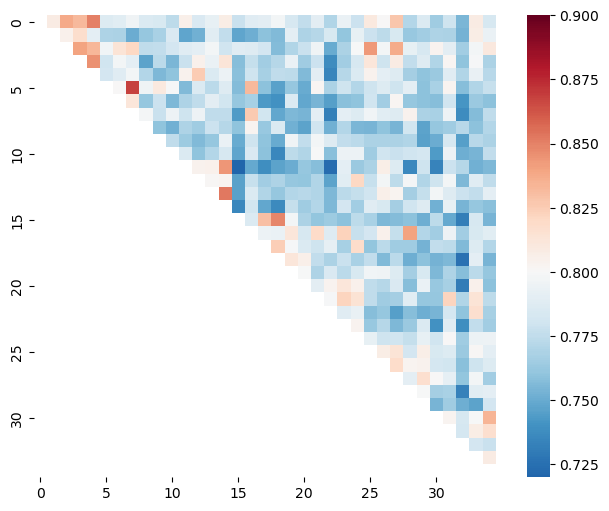

In [163]:
# 將下三角部分的值設置為NaN，只保留上三角
mask = np.tril(np.ones_like(similarity_matrix, dtype=bool))
similarity_matrix[mask] = np.nan

# 將矩陣轉換為DataFrame
#col = list(range(1, 36))
df_S = pd.DataFrame(similarity_matrix)

# 使用Seaborn繪製熱度圖
plt.figure(figsize=(8, 6))
sns.heatmap(df_S, annot=False, cmap='RdBu_r', square=True, xticklabels = 5, yticklabels = 5, center = 0.80, vmin = 0.72, vmax = 0.900)
#plt.xlabel('文本編號')

<AxesSubplot: >

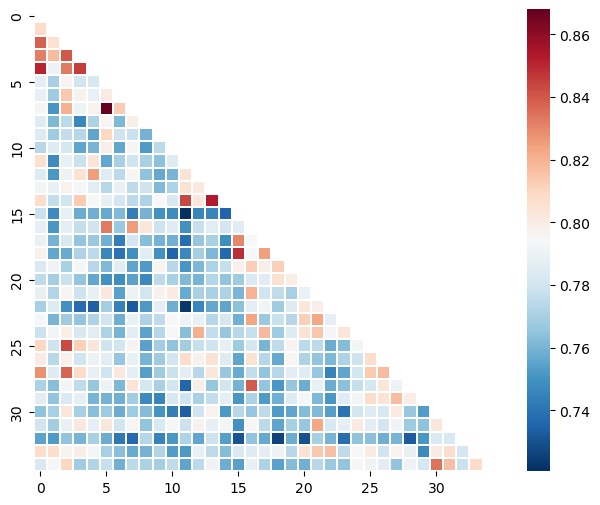

In [90]:
# 創建一個示例的相似性矩陣（用隨機數代替）
random_matrix = np.random.rand(5, 5)

# 將下三角部分的值設置為NaN，只保留上三角
mask = np.triu(np.ones_like(similarity_matrix, dtype=bool))
similarity_matrix[mask] = np.nan

# 將矩陣轉換為DataFrame
#col = list(range(1, 36))
df = pd.DataFrame(similarity_matrix)

# 使用Seaborn繪製熱度圖
plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=False, cmap='RdBu_r', square=True, xticklabels = 5, yticklabels = 5, linewidths = 0.01)
#plt.xlabel('文本編號')

In [46]:
# transform to np array
array1 = np.array(embeddings[0])
array2 = np.array(embeddings[2])

# 計算余弦相似性
similarity = cosine_similarity([array1], [array2])

# 因為cosine_similarity返回一個矩陣，我們需要提取出相似性值
cosine_similarity_value = similarity[0][0]

print("余弦相似性:", cosine_similarity_value)

余弦相似性: 0.838082670524408


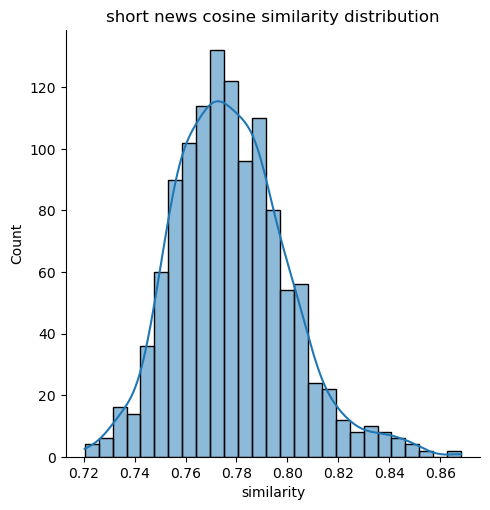

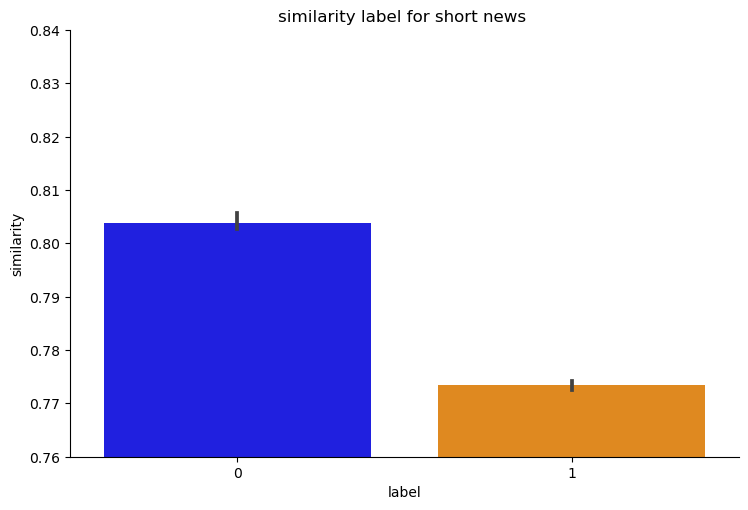

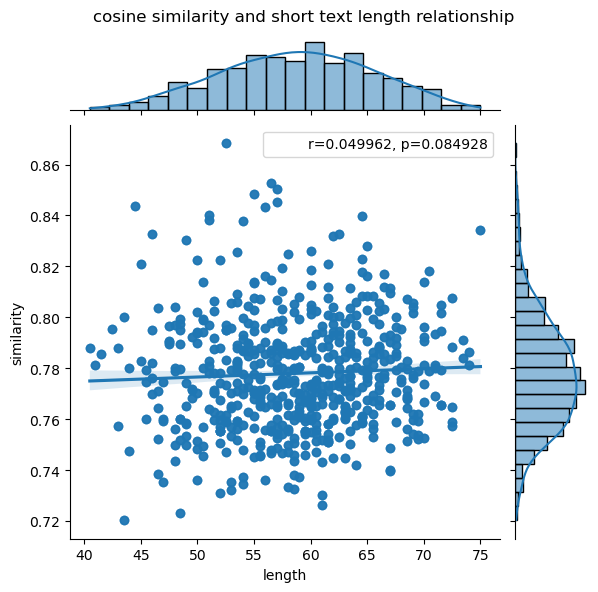

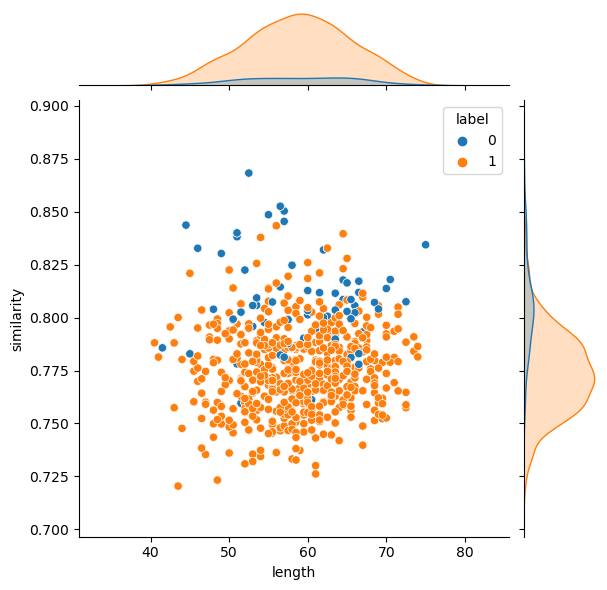

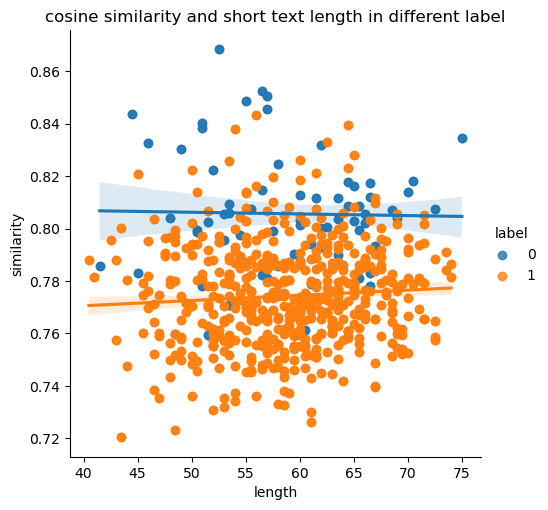

In [120]:
df_short = df_short.drop(df_short[df_short['similarity'] > 0.9999].index)
g = sns.displot(data=df_short, x="similarity", kde=True)
g.set(title = 'short news cosine similarity distribution')
g = sns.catplot(data = df_short, x = 'label', y = 'similarity', errorbar=('ci', 68), kind = 'bar', aspect = 1.5, estimator = np.median, palette = ['blue', 'darkorange'])
g.set(title = 'similarity label for short news ', ylim =(0.76, 0.84) )

#
graph = sns.jointplot(data = df_short, x = 'length', y = 'similarity', kind = 'reg')
r, p = stats.pearsonr(df_short['length'], df_short['similarity'])

phantom, = graph.ax_joint.plot([], [], linestyle="", alpha=0)
graph.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])
graph.fig.suptitle("cosine similarity and short text length relationship")
graph.fig.subplots_adjust(top=0.93)

g = sns.jointplot(data = df_short,x = 'length', y = 'similarity', hue = 'label')

g = sns.lmplot(data = df_short, x = 'length', y = 'similarity', hue = 'label')
g.set(title = 'cosine similarity and short text length in different label')

### check similaritiy difference between same and different domain

In [101]:
# 拆分DataFrame成兩個群組，分別對應不同的label
group0 = df_short[df_short['label'] == 0]['similarity']
group1 = df_short[df_short['label'] == 1]['similarity']
t_statistic, p_value = stats.ttest_ind(group0, group1)

# 顯示結果
print("t-統計值:", t_statistic)
print("p-值:", p_value)


t-統計值: 24.349661990822884
p-值: 4.228092558324181e-107


## Middle news -> 100-200 words

In [165]:
# 讀取txt檔案
f = open('./data/news_middle.txt', 'r', encoding='utf-8')
lines = f.readlines()
print(lines)
# 將新聞頭條和對應的類別名稱分別存成兩個list
headlines = [line.strip() for line in lines]
categories = ['體育']*5 + ['金融']*5 + ['政治']*5 + ['美妝']*5 + ['醫學']*5 + ['藝術']*5 + ['科學']*5

# 將兩個list轉換為dataframe
df = pd.DataFrame({'headlines': headlines, 'category': categories})

f.close()
# 印出dataframe
print(df)

embeds_m = []
for i in df['headlines']:
    embedding = get_embedding(i, model="text-embedding-ada-002")
    embeds_m.append(embedding)

['2021年東京奧運會，臺灣運動員勇奪2金4銀6銅的成績，成功創下最佳歷史記錄。可惜的是隨著東京奧運會的結束，一度燃起的體育風潮逐漸變得冷靜。民眾們開始思考臺灣體育的環境與制度，希望藉此為辛勞的體育從業人員、教練與運動員們，打造更好更優質的訓練環境。國統國際股份有限公司董事長洪雅滿，於東京奧運會期間不斷關注臺灣運動員的各項賽事與表現，對運動員的努力與付出深感敬佩，為延續臺灣體育的感動時刻，故決議身體力行力挺臺灣體育發展。\n', '無論是體育課程，或是教室裡的常態課程，最終目的都是希望藉由過程讓學生有所收穫，進而內化、成長。體育課程一直以來給大家的想像，就是在課程當中藉由原本陌生的身體活動有所成長，甚至從原本個人動作練習，發展出團體配合，進而模擬團體生活中的相處模式。\n', '湖人與勇士兩隊是截然不同特性球隊，勇士走快、湖人則打穩定節奏，這當然都與主力球員特性有關，經過五戰消耗後，詹皇回主場一定避免夜長夢多、全力想關門，但傷兵與相關人員體能恢復，絕對是左右戰局的關鍵(據聞湖人第五戰傷了AD)。就運動恢復這件事看來，NBA當然在科研、營養、恢復都是世界級，但休息與調整，還是要回到球員本身；勇士隊長期是自律很高的球隊文化，沒聽過在大賽期不適合的活動，恢復部分應該會比湖人略佳。\n', '採用低肩側投投法的林琨瑋，雖然在職棒時期沒有留下什麼顯赫的成績，但業餘時期他可是台灣棒球界少數贏過古巴隊的投手。事實上，他也是國際棒總認證的重大國際賽中，扣除邀請賽性質的洲際盃，在2015年世界12強棒球賽預賽台灣以4：1擊敗古巴隊之前，上一位擊敗古巴隊的投手，而這兩場比賽之間相隔了足足有29年。\n', '時間回到2021年7月11日，英國倫敦，溫布利球場。 Bukayo Saka帶著忐忑不安的心情走上了12碼罰球點。為義大利操刀第五點的12碼罰球大師Jorginho意外射失，為這場決定歐洲冠軍的大戰留下了懸念。萬籟俱寂。他深吸了一口氣，快步衝向皮球，將皮球打向球門右側。皮球劃出的弧線沒能突破義大利年輕國門Gianluigi Donnarumma的十指關。3:2，義大利抱回了歐國杯冠軍。粉碎了英格蘭人讓足球回家的美夢。\n', '該主管說，因「約定轉帳」可一次單筆做至少200萬元起跳的大額轉帳，日前爆發銀行員勾結詐團，就是行員將詐團提供的人頭帳戶約定轉帳金額大舉調高，讓詐團迅速轉移

      similarity  label  length
0       1.000000      0   211.0
1       0.830982      0   165.5
2       0.819581      0   206.0
3       0.812684      0   180.0
4       0.800279      0   210.5
...          ...    ...     ...
1220    0.810410      0   168.5
1221    0.762474      0   139.5
1222    0.827603      0   173.5
1223    0.757817      0   199.0
1224    1.000000      0   149.0

[1225 rows x 3 columns]
label 0 count: 0    175
Name: label, dtype: int64
label 1 count: 1    1050
Name: label, dtype: int64


[Text(0.5, 1.0, 'Heatmap for middle news')]

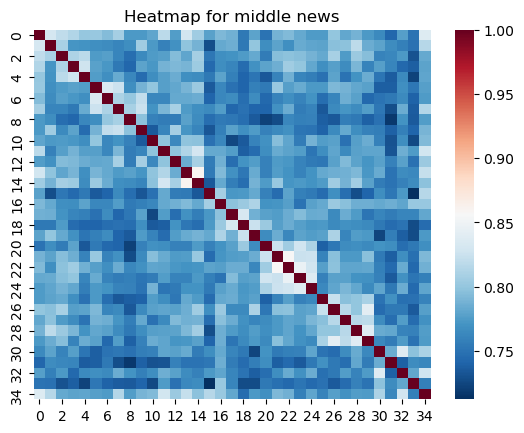

In [166]:
#
embeddings = embeds_m
labels = df['category']

similarity_matrix = cosine_similarity(embeddings)

# 創建新的DataFrame
df_middle = pd.DataFrame()

# 將相似度值添加到新的DataFrame中
df_middle['similarity'] = similarity_matrix.flatten()

# 計算標籤相似度並添加到新的DataFrame中
label_similarity = []
length = []
for i in range(len(labels)):
    for j in range(len(labels)):
        if i == j:
            label_similarity.append(0)
        elif labels[i] == labels[j]:
            label_similarity.append(0)
        else:
            label_similarity.append(1)
        mean =  (len(lines[i][:-1]) + len(lines[j][:-1]))/2
        length.append(mean)
df_middle['label'] = label_similarity
df_middle['length'] = length

# 顯示DataFrame
print(df_middle)

# 篩選出labels為0的列並計算次數
label_0_count = df_middle[df_middle['label'] == 0]['label'].value_counts()

# 篩選出labels為1的列並計算次數
label_1_count = df_middle[df_middle['label'] == 1]['label'].value_counts()

print('label 0 count:', label_0_count)
print('label 1 count:', label_1_count)

g = sns.heatmap(similarity_matrix, cmap="RdBu_r")
g.set(title = 'Heatmap for middle news')

In [105]:
Len = df_middle['length']
print(np.mean(Len))
print(np.std(Len))

184.82857142857142
30.36138793848233


In [170]:
# 創建一個示例的相似性矩陣（用隨機數代替）
random_matrix = np.random.rand(5, 5)

# 將下三角部分的值設置為NaN，只保留上三角
mask = np.tril(np.ones_like(similarity_matrix, dtype=bool))
similarity_matrix[mask] = np.nan

# 將矩陣轉換為DataFrame
#col = list(range(1, 36))
df_M = pd.DataFrame(similarity_matrix)

<AxesSubplot: >

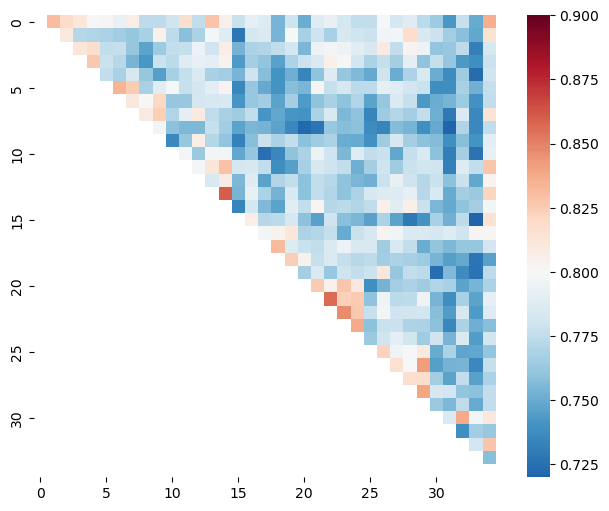

In [173]:
# 使用Seaborn繪製熱度圖
plt.figure(figsize=(8, 6))
sns.heatmap(df_M, annot=False, cmap='RdBu_r', square=True, xticklabels = 5, yticklabels = 5, center = 0.80, vmin = 0.72, vmax = 0.900)
#plt.xlabel('文本編號')

In [168]:
df_M

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,NaN,0.830982,0.819581,0.812684,0.800279,0.801530,0.793349,0.807326,0.774069,0.774073,...,0.775194,0.799129,0.781946,0.787877,0.773220,0.764179,0.742289,0.777036,0.749702,0.836020
1,NaN,NaN,0.809447,0.771525,0.770479,0.768269,0.765244,0.761005,0.767221,0.805319,...,0.778945,0.796081,0.797476,0.818063,0.784612,0.779021,0.765562,0.758229,0.748503,0.814764
2,NaN,NaN,NaN,0.811792,0.817596,0.775172,0.776358,0.761620,0.746186,0.764085,...,0.782744,0.808339,0.774875,0.802513,0.794594,0.760191,0.762353,0.773742,0.731314,0.782665
3,NaN,NaN,NaN,NaN,0.826688,0.777905,0.772635,0.753527,0.742141,0.778868,...,0.768304,0.776651,0.765895,0.790510,0.759887,0.776540,0.761545,0.743116,0.737893,0.779005
4,NaN,NaN,NaN,NaN,NaN,0.775377,0.767542,0.783242,0.761854,0.745312,...,0.749026,0.779089,0.750269,0.769678,0.784320,0.750677,0.736907,0.764305,0.722976,0.780148
5,NaN,NaN,NaN,NaN,NaN,NaN,0.833885,0.825308,0.767300,0.788493,...,0.773733,0.791678,0.787661,0.781573,0.777663,0.738134,0.737779,0.767492,0.751649,0.776516
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.810677,0.800652,0.820819,...,0.746643,0.761415,0.785747,0.777638,0.743192,0.750261,0.753197,0.764260,0.740081,0.775159
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.808013,0.823651,...,0.734142,0.764114,0.771282,0.765737,0.775368,0.751638,0.728636,0.784935,0.736101,0.814170
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.797559,...,0.737493,0.734649,0.757111,0.753142,0.738488,0.748948,0.717819,0.770373,0.735583,0.775499
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.740224,0.764615,0.782656,0.766329,0.758839,0.756982,0.738305,0.757715,0.740485,0.788982


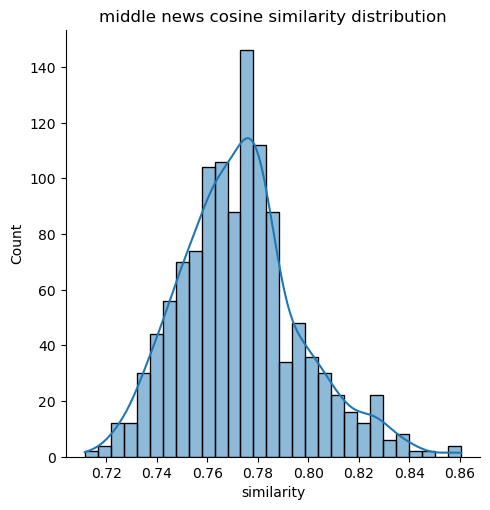

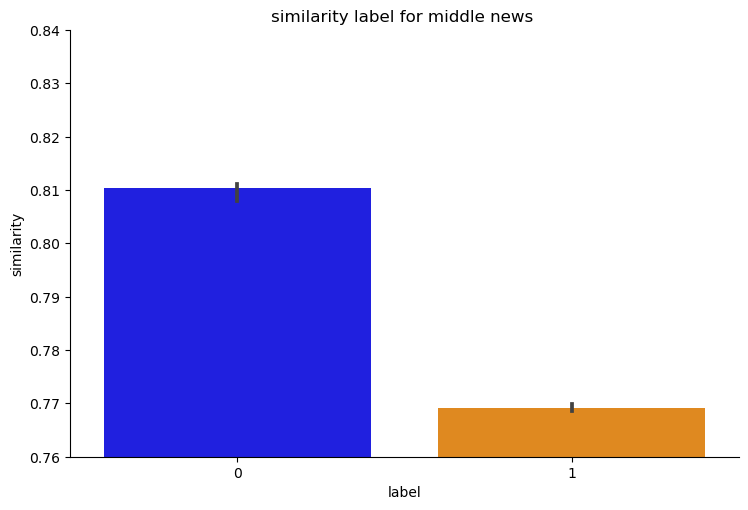

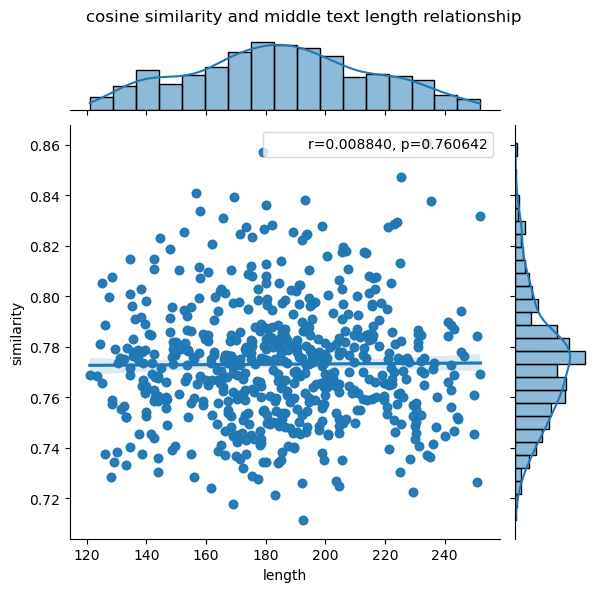

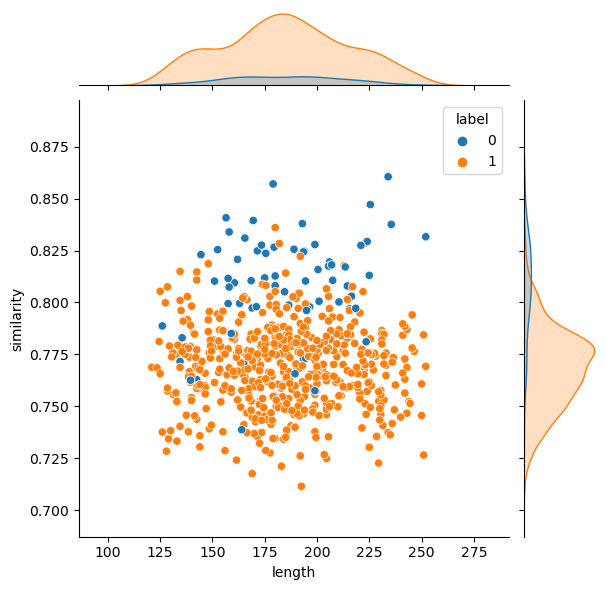

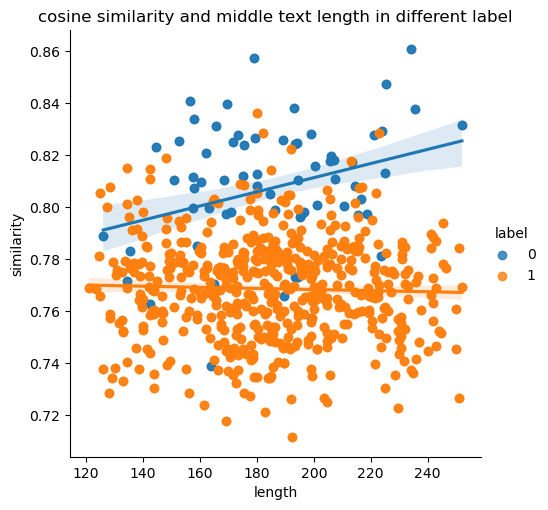

In [119]:
#
df_middle = df_middle.drop(df_middle[df_middle['similarity'] > 0.9999].index)
g = sns.displot(data=df_middle, x="similarity", kde=True)
g.set(title = 'middle news cosine similarity distribution')
g = sns.catplot(data = df_middle, x = 'label', y = 'similarity', errorbar=('ci', 68), kind = 'bar', aspect = 1.5, estimator = np.median, palette = ['blue', 'darkorange'])
g.set(title = 'similarity label for middle news ', ylim =(0.76, 0.84))

#
graph = sns.jointplot(data = df_middle, x = 'length', y = 'similarity', kind = 'reg')
r, p = stats.pearsonr(df_middle['length'], df_middle['similarity'])

phantom, = graph.ax_joint.plot([], [], linestyle="", alpha=0)
graph.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])
graph.fig.suptitle("cosine similarity and middle text length relationship")
graph.fig.subplots_adjust(top=0.93)

g = sns.jointplot(data = df_middle,x = 'length', y = 'similarity', hue = 'label')

g = sns.lmplot(data = df_middle, x = 'length', y = 'similarity', hue = 'label')
g.set(title = 'cosine similarity and middle text length in different label')

### check similarity difference

In [109]:
# 拆分DataFrame成兩個群組，分別對應不同的label
group0 = df_middle[df_middle['label'] == 0]['similarity']
group1 = df_middle[df_middle['label'] == 1]['similarity']
t_statistic, p_value = stats.ttest_ind(group0, group1)

# 顯示結果
print("t-統計值:", t_statistic)
print("p-值:", p_value)


t-統計值: 26.658632867818103
p-值: 8.158408093501803e-124


## long news -> 300-400up words

In [284]:
# 讀取txt檔案
f = open('./data/news_long.txt', 'r', encoding='utf-8')
lines = f.readlines()
print(lines)
# 將新聞頭條和對應的類別名稱分別存成兩個list
headlines = [line.strip() for line in lines]
categories = ['體育']*5 + ['金融']*5 + ['政治']*5 + ['美妝']*5 + ['醫學']*5 + ['藝術']*5 + ['科學']*5

# 將兩個list轉換為dataframe
df = pd.DataFrame({'headlines': headlines, 'category': categories})

content = lines
f.close()
# 印出dataframe
print(df)

embeds_l = []
for i in df['headlines']:
    embedding = get_embedding(i, model="text-embedding-ada-002")
    embeds_l.append(embedding)

['洪雅滿董事長在因緣際會下發現，有臺灣跳水發源地之稱的「高雄國際游泳池跳水訓練場地」，於1996年竣工後，變成為臺灣跳水運動員培育的重點基地，截至今日已有20多年的使用年限。再隨著設備的老舊、科技的進步，目前的環境已不足以選手們日常的訓練使用。為此，國統企業決定身先士卒，贊助高雄游泳委員會跳水隊訓練用之跳板，期盼能讓運動員在更舒適的環境進行訓練。洪雅滿董事長也表示，除以行動力來改善臺灣基層訓練基地，更期望能藉此帶起臺灣企業「撐體育」的風潮。高雄跳水隊目前有林子翔、李淵明、賴昱燕三名教練，除積極投入基層訓練外，亦努力推廣全民跳水運動，希望跳水運動在臺灣有更多的參與率和普及率。此外，林子翔教練表示，跳水隊是高雄水上運動的重點培育項目，在高雄游泳委員會黃俊傑主委、蔡金晏副主委、林智鴻副主委及許峰銘總幹事等的長期推廣下，持續穩步的成長茁壯。\n', '我們從不少運動選手的自傳或訪談當中，都可以發現到的共通點就是「目標設定」，目標的設定可以提供明確方向，甚至讓自己在努力過程中遇到低潮，不會因此一蹶不振。但目標設定不能過於天馬行空，那可能會讓隨時放棄都顯得合情合理。頂尖運動員設定目標的案例可以看看大谷翔平，在高中一年級就以「曼陀羅九宮格」設定了八球團第一指名的目標，更把九宮格加以細分，其中除了球場技能、體能面向的分項能力，也包含了「運氣」、「人際關係」以及「心理層面」等內容。阿耕過去在幾次講座，都會藉由這張表格和年輕運動員分享，即便朝著目標前進的大谷翔平，最後沒有成為職棒選手，憑藉這樣的規劃，他在成長過程中那些取得的潛在能力，想必也能在各領域有優異表現。目標設定無論是在運動訓練、學習新事物，甚至是新創事業，都是非常重要的一個環節，不僅大谷翔平，目前你所看到絕大多數的頂尖運動員，都幫自己設定了目標，或許有一個遠大的終極目標，但每個階段的小目標，不會太困難，卻又不會遙遠到無法觸及，才是推使向前的重要關鍵！\n', '有意思的是，目前勇士為落後一方，應該會有絕望感受。弔詭的是，就目前新聞披露出的勇士訪談，並沒有透露出這樣的訊息，有別於去年跟塞爾蒂克總冠軍賽時，那樣的訊息內容。或許勇士球員們真的沒那麼緊張，也或許與目前球隊內部有著壓抑住的茶壺內風暴有關。有別於去年 Poole的寫意進攻，季後賽的Poole就是沒那麼流暢，這肯定就是球員彼此的矛盾，還沒化解開來，影響了那幾微秒的反應與行

In [99]:
content[0][:-1]

'洪雅滿董事長在因緣際會下發現，有臺灣跳水發源地之稱的「高雄國際游泳池跳水訓練場地」，於1996年竣工後，變成為臺灣跳水運動員培育的重點基地，截至今日已有20多年的使用年限。再隨著設備的老舊、科技的進步，目前的環境已不足以選手們日常的訓練使用。為此，國統企業決定身先士卒，贊助高雄游泳委員會跳水隊訓練用之跳板，期盼能讓運動員在更舒適的環境進行訓練。洪雅滿董事長也表示，除以行動力來改善臺灣基層訓練基地，更期望能藉此帶起臺灣企業「撐體育」的風潮。高雄跳水隊目前有林子翔、李淵明、賴昱燕三名教練，除積極投入基層訓練外，亦努力推廣全民跳水運動，希望跳水運動在臺灣有更多的參與率和普及率。此外，林子翔教練表示，跳水隊是高雄水上運動的重點培育項目，在高雄游泳委員會黃俊傑主委、蔡金晏副主委、林智鴻副主委及許峰銘總幹事等的長期推廣下，持續穩步的成長茁壯。'

      similarity  label  length
0       1.000000      0   370.0
1       0.836680      0   400.5
2       0.819157      0   335.5
3       0.820165      0   344.0
4       0.822147      0   413.5
...          ...    ...     ...
1220    0.810278      0   427.5
1221    0.752038      0   411.0
1222    0.838555      0   400.5
1223    0.760020      0   414.0
1224    1.000000      0   418.0

[1225 rows x 3 columns]
label 0 count: 0    175
Name: label, dtype: int64
label 1 count: 1    1050
Name: label, dtype: int64


[Text(0.5, 1.0, 'Heatmap for long news')]

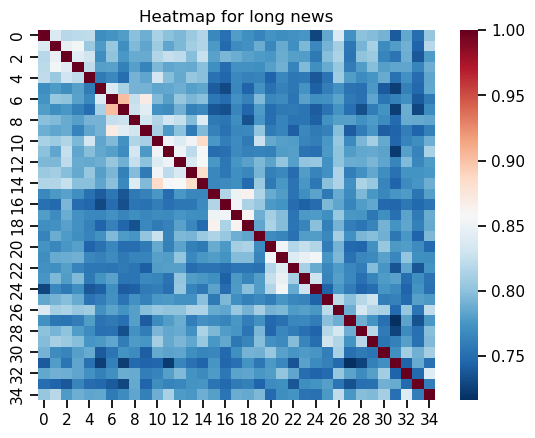

In [285]:
#
embeddings = embeds_l
labels = df['category']

similarity_matrix = cosine_similarity(embeddings)

# 創建新的DataFrame
df_long = pd.DataFrame()

# 將相似度值添加到新的DataFrame中
df_long['similarity'] = similarity_matrix.flatten()

# 計算標籤相似度並添加到新的DataFrame中
label_similarity = []
length = []
for i in range(len(labels)):
    for j in range(len(labels)):
        if i == j:
            label_similarity.append(0)
        elif labels[i] == labels[j]:
            label_similarity.append(0)
        else:
            label_similarity.append(1)
        mean =  (len(lines[i][:-1]) + len(lines[j][:-1]))/2
        length.append(mean)
df_long['label'] = label_similarity
df_long['length'] = length
# 顯示DataFrame
print(df_long)

# 篩選出labels為0的列並計算次數
label_0_count = df_long[df_long['label'] == 0]['label'].value_counts()

# 篩選出labels為1的列並計算次數
label_1_count = df_long[df_long['label'] == 1]['label'].value_counts()

print('label 0 count:', label_0_count)
print('label 1 count:', label_1_count)

g = sns.heatmap(similarity_matrix, cmap="RdBu_r")
g.set(title = 'Heatmap for long news')

<AxesSubplot: >

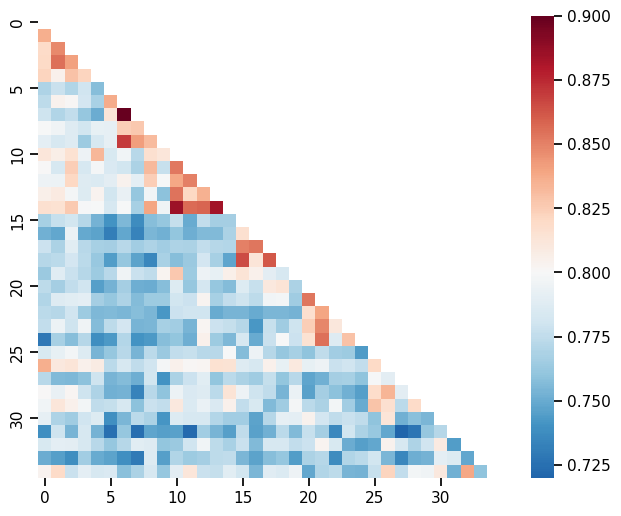

In [289]:
# 創建一個示例的相似性矩陣（用隨機數代替）
sns.set_context('notebook')
random_matrix = np.random.rand(5, 5)

# 將下三角部分的值設置為NaN，只保留上三角
mask = np.triu(np.ones_like(similarity_matrix, dtype=bool))
similarity_matrix[mask] = np.nan

# 將矩陣轉換為DataFrame
#col = list(range(1, 36))
df_L = pd.DataFrame(similarity_matrix)

# 使用Seaborn繪製熱度圖
plt.figure(figsize=(8, 6))
sns.heatmap(df_L, annot=False, cmap='RdBu_r', square=True, xticklabels = 5, yticklabels = 5, center = 0.80, vmin = 0.72, vmax = 0.90)
#plt.xlabel('文本編號')

In [115]:
Len = df_long['length']
print(np.mean(Len))
print(np.std(Len))

378.8285714285714
35.890104372051276


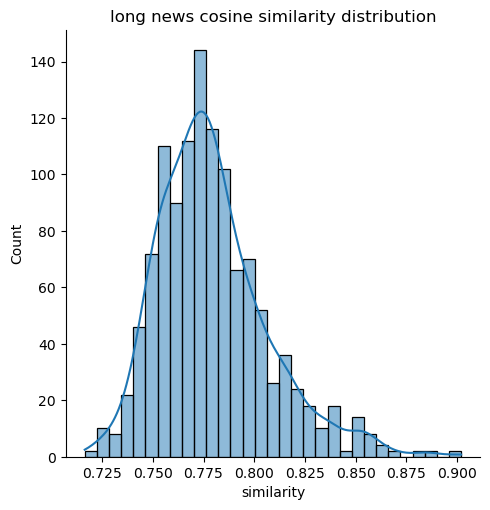

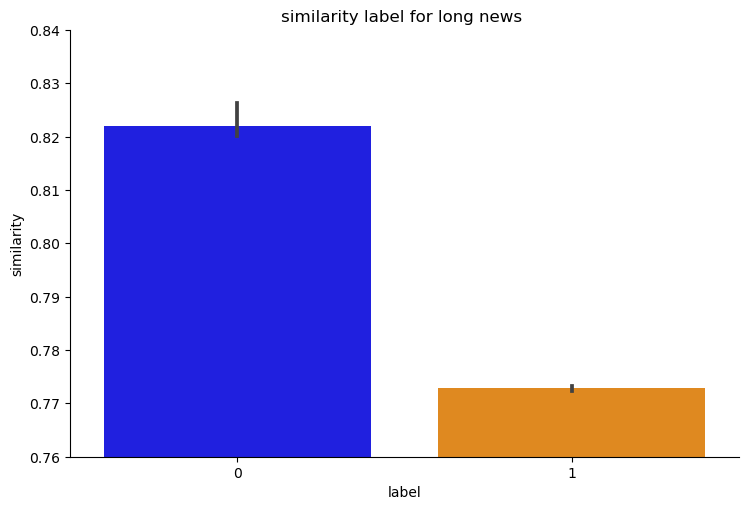

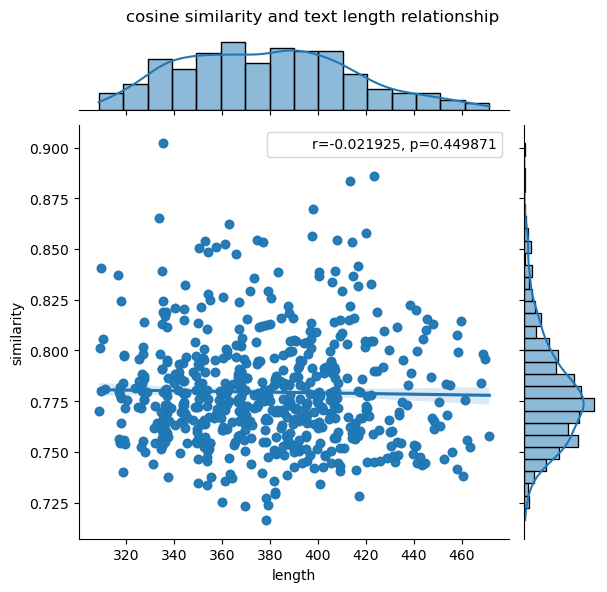

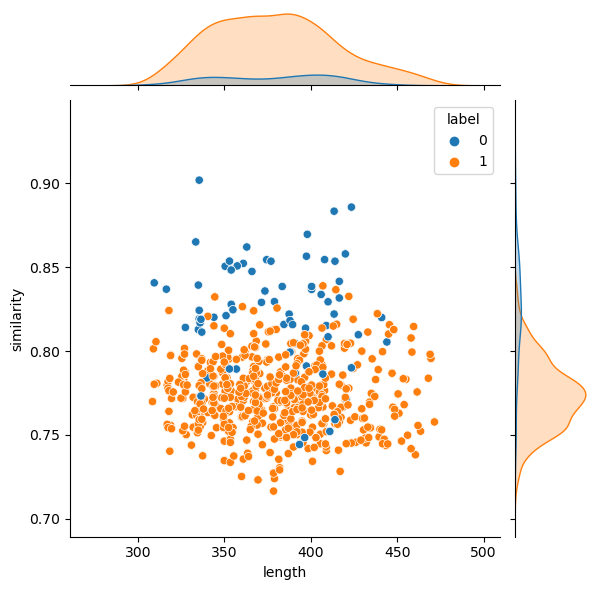

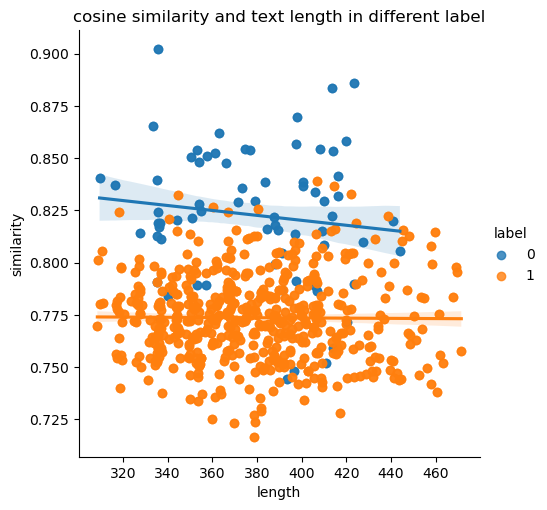

In [118]:

df_long = df_long.drop(df_long[df_long['similarity'] > 0.9999].index)
g = sns.displot(data=df_long, x="similarity", kde=True)
g.set(title = 'long news cosine similarity distribution')
g = sns.catplot(data = df_long, x = 'label', y = 'similarity', errorbar=('ci', 68), kind = 'bar', aspect = 1.5, estimator = np.median, palette = ['blue', 'darkorange'])
g.set(title = 'similarity label for long news ', ylim =(0.76, 0.84) )
import scipy.stats as stats

graph = sns.jointplot(data = df_long, x = 'length', y = 'similarity', kind = 'reg')
r, p = stats.pearsonr(df_long['length'], df_long['similarity'])

phantom, = graph.ax_joint.plot([], [], linestyle="", alpha=0)
graph.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])
graph.fig.suptitle("cosine similarity and text length relationship")
graph.fig.subplots_adjust(top=0.93)

g = sns.jointplot(data = df_long,x = 'length', y = 'similarity', hue = 'label')

g = sns.lmplot(data = df_long, x = 'length', y = 'similarity', hue = 'label')
g.set(title = 'cosine similarity and text length in different label')

### check similarity difference

In [185]:
# 拆分DataFrame成兩個群組，分別對應不同的label
df_long = df_long[df_long['similarity'] < 0.999999]
group0 = df_long[df_long['label'] == 0]['similarity']
group1 = df_long[df_long['label'] == 1]['similarity']
t_statistic, p_value = stats.ttest_ind(group0, group1)

# 顯示結果
print("t-統計值:", t_statistic)
print("p-值:", p_value)

t-統計值: 24.49487802158562
p-值: 1.366559349864036e-107


## Compare Texts with different lengths

In [175]:
print(len(df_short.label), len(df_middle.label), len(df_middle.label))
x = list(df_short['similarity']) + list(df_middle['similarity'])
len(x)

1225 1225 1225


2450

In [177]:
df_all = pd.DataFrame()
df_all['ID'] = ['short']*1225 + ['mid']*1225 + ['long']*1225
df_all['similarity'] = list(df_short['similarity']) + list(df_middle['similarity']) + list(df_long['similarity'])
df_all['label'] = list(df_short['label']) + list(df_middle['label']) + list(df_long['label'])
df_all['length'] = list(df_short['length']) + list(df_middle['length']) + list(df_long['length'])

df_all

,ID,similarity,label,length
0,short,1.000000,0,62.0
1,short,0.808280,0,64.5
2,short,0.838083,0,51.0
3,short,0.831808,0,62.0
4,short,0.850331,0,57.0
...,...,...,...,...
3670,long,0.810224,0,427.5
3671,long,0.752015,0,411.0
3672,long,0.838388,0,400.5
3673,long,0.759110,0,414.0


In [187]:
df_fil = df_all[df_all['similarity'] < 0.999999999]
df_fil

,ID,similarity,label,length
1,short,0.808280,0,64.5
2,short,0.838083,0,51.0
3,short,0.831808,0,62.0
4,short,0.850331,0,57.0
5,short,0.786642,1,58.5
...,...,...,...,...
3669,long,0.795849,1,369.0
3670,long,0.810224,0,427.5
3671,long,0.752015,0,411.0
3672,long,0.838388,0,400.5


In [216]:
#標籤長度是否影響similarity 相同領域
from scipy.stats import f_oneway

group0 = df_fil[df_fil['label'] == 0]


# 使用ANOVA分析
short_group = group0[group0['ID'] == 'short']['similarity']
middle_group = group0[group0['ID'] == 'mid']['similarity']
long_group = group0[group0['ID'] == 'long']['similarity']

f_statistic, p_value = f_oneway(short_group, middle_group, long_group)

# 判斷結果
alpha = 0.05  # 顯著性水準
if p_value < alpha:
    print("存在統計上的差異：標籤長度影響相似性")
else:
    print("統計上無法確定差異：標籤長度不影響相似性")

print(f_statistic)
print(p_value)

存在統計上的差異：標籤長度影響相似性
17.840602607155677
3.678229529824883e-08


In [244]:
#標籤長度是否影響similarity 不同領域
from scipy.stats import f_oneway

group1 = df_fil[df_fil['label'] == 1]


# 使用ANOVA分析
short_group = group1[group1['ID'] == 'short']['similarity']
middle_group = group1[group1['ID'] == 'mid']['similarity']
long_group = group1[group1['ID'] == 'long']['similarity']

f_statistic, p_value = f_oneway(short_group, middle_group, long_group)

# 判斷結果
alpha = 0.05  # 顯著性水準
if p_value < alpha:
    print("存在統計上的差異：標籤長度影響相似性")
else:
    print("統計上無法確定差異：標籤長度不影響相似性")

print(f_statistic)
print(p_value)
f_oneway(short_group, middle_group, long_group)

存在統計上的差異：標籤長度影響相似性
25.610544126413643
9.268888077673969e-12


F_onewayResult(statistic=25.610544126413643, pvalue=9.268888077673969e-12)

In [218]:
group1

,ID,similarity,label,length
5,short,0.786642,1,58.5
6,short,0.788309,1,66.0
7,short,0.795386,1,56.0
8,short,0.785687,1,56.5
9,short,0.784446,1,57.0
...,...,...,...,...
3665,long,0.777260,1,420.5
3666,long,0.822228,1,438.5
3667,long,0.775846,1,385.5
3668,long,0.797617,1,385.5


In [234]:
#長度是否影響similarity 相同領域文本
import statsmodels.api as sm


# 添加截距項（intercept） 
group0['intercept'] = 1

# 構建回歸模型
model = sm.OLS(group0['similarity'], group0[['intercept', 'length']])

# 進行回歸分析
results = model.fit()

# 查看回歸結果摘要
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     32.19
Date:                Tue, 29 Aug 2023   Prob (F-statistic):           2.62e-08
Time:                        12:36:23   Log-Likelihood:                 927.29
No. Observations:                 420   AIC:                            -1851.
Df Residuals:                     418   BIC:                            -1842.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8004      0.002    333.832      0.0

C:\Users\edwar\AppData\Local\Temp\ipykernel_34500\1698820533.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group0['intercept'] = 1


In [243]:
group1

,ID,similarity,label,length,intercept,length_standardized,sim_standardized
5,short,0.786642,1,58.5,1,-1.107674,0.718108
6,short,0.788309,1,66.0,1,-1.051903,0.801041
7,short,0.795386,1,56.0,1,-1.126265,1.153077
8,short,0.785687,1,56.5,1,-1.122547,0.670590
9,short,0.784446,1,57.0,1,-1.118829,0.608879
...,...,...,...,...,...,...,...
3665,long,0.777260,1,420.5,1,1.584228,0.251401
3666,long,0.822228,1,438.5,1,1.718080,2.488378
3667,long,0.775846,1,385.5,1,1.323962,0.181063
3668,long,0.797617,1,385.5,1,1.323962,1.264091


In [235]:
#長度是否影響similarity 相異領域文本
import statsmodels.api as sm


# 添加截距項（intercept） 
group1['intercept'] = 1

# 構建回歸模型
model = sm.OLS(group1['similarity'], group1[['intercept', 'length']])

# 進行回歸分析
results = model.fit()

# 查看回歸結果摘要
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                  0.003559
Date:                Tue, 29 Aug 2023   Prob (F-statistic):              0.952
Time:                        12:36:38   Log-Likelihood:                 7837.7
No. Observations:                3150   AIC:                        -1.567e+04
Df Residuals:                    3148   BIC:                        -1.566e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7722      0.001   1172.346      0.0

C:\Users\edwar\AppData\Local\Temp\ipykernel_34500\348328499.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group1['intercept'] = 1


In [221]:
# 計算 length 列的平均值和標準差
mean_length = group0['length'].mean()
stddev_length = group0['length'].std()
mean_sim = group0['similarity'].mean()
stddev_sim = group0['similarity'].std()
# 進行標準化
group0['length_standardized'] = (group0['length'] - mean_length) / stddev_length
group0['sim_standardized'] = (group0['similarity'] - mean_sim) / stddev_sim
group0

C:\Users\edwar\AppData\Local\Temp\ipykernel_34500\2273416314.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group0['length_standardized'] = (group0['length'] - mean_length) / stddev_length
C:\Users\edwar\AppData\Local\Temp\ipykernel_34500\2273416314.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group0['sim_standardized'] = (group0['similarity'] - mean_sim) / stddev_sim


,ID,similarity,label,length,intercept,length_standardized,sim_standardized
1,short,0.808280,0,64.5,1,-1.065278,-0.128443
2,short,0.838083,0,51.0,1,-1.165877,0.949780
3,short,0.831808,0,62.0,1,-1.083908,0.722772
4,short,0.850331,0,57.0,1,-1.121166,1.392927
35,short,0.808280,0,64.5,1,-1.065278,-0.128443
...,...,...,...,...,...,...,...
3639,long,0.759110,0,414.0,1,1.539102,-1.907394
3670,long,0.810224,0,427.5,1,1.639701,-0.058128
3671,long,0.752015,0,411.0,1,1.516747,-2.164066
3672,long,0.838388,0,400.5,1,1.438504,0.960818


In [227]:
# 計算 length 列的平均值和標準差
mean_length = group1['length'].mean()
stddev_length = group1['length'].std()
mean_sim = group1['similarity'].mean()
stddev_sim = group1['similarity'].std()
# 進行標準化
group1['length_standardized'] = (group1['length'] - mean_length) / stddev_length
group1['sim_standardized'] = (group1['similarity'] - mean_sim) / stddev_sim
group1

C:\Users\edwar\AppData\Local\Temp\ipykernel_34500\1147855058.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group1['length_standardized'] = (group1['length'] - mean_length) / stddev_length
C:\Users\edwar\AppData\Local\Temp\ipykernel_34500\1147855058.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group1['sim_standardized'] = (group1['similarity'] - mean_sim) / stddev_sim


,ID,similarity,label,length,intercept,length_standardized,sim_standardized
5,short,0.786642,1,58.5,1,-1.107674,0.718108
6,short,0.788309,1,66.0,1,-1.051903,0.801041
7,short,0.795386,1,56.0,1,-1.126265,1.153077
8,short,0.785687,1,56.5,1,-1.122547,0.670590
9,short,0.784446,1,57.0,1,-1.118829,0.608879
...,...,...,...,...,...,...,...
3665,long,0.777260,1,420.5,1,1.584228,0.251401
3666,long,0.822228,1,438.5,1,1.718080,2.488378
3667,long,0.775846,1,385.5,1,1.323962,0.181063
3668,long,0.797617,1,385.5,1,1.323962,1.264091


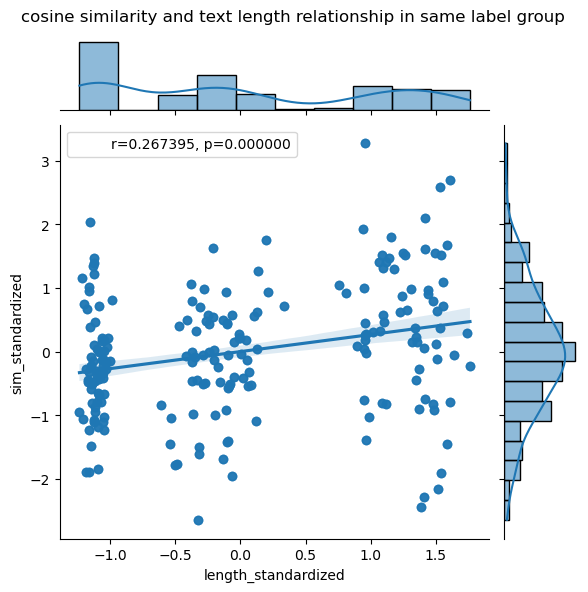

In [213]:
graph = sns.jointplot(data = group0, x = 'length_standardized', y = 'sim_standardized', kind = 'reg')
r, p = stats.pearsonr(group0['length_standardized'], group0['sim_standardized'])

phantom, = graph.ax_joint.plot([], [], linestyle="", alpha=0)
graph.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])
graph.fig.suptitle("cosine similarity and text length relationship in same label group")
graph.fig.subplots_adjust(top=0.93)

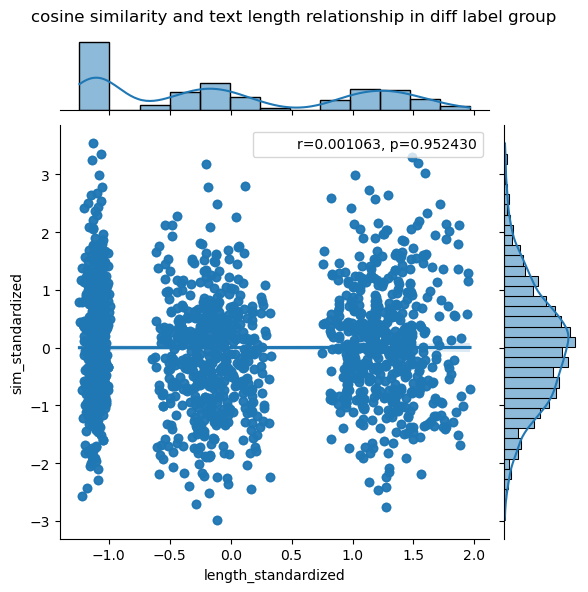

In [ ]:
graph = sns.jointplot(data = group1, x = 'length_standardized', y = 'sim_standardized', kind = 'reg')
r, p = stats.pearsonr(group1['length_standardized'], group1['sim_standardized'])

phantom, = graph.ax_joint.plot([], [], linestyle="", alpha=0)
graph.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])
graph.fig.suptitle("cosine similarity and text length relationship in diff label group")
graph.fig.subplots_adjust(top=0.93)

In [240]:
lst = []
for i in df_fil['label']:
    if i == 0:
        lst.append('same')
    else:
        lst.append('different')
df_fil['Label'] = lst
df_fil

C:\Users\edwar\AppData\Local\Temp\ipykernel_34500\4080505460.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fil['Label'] = lst


,ID,similarity,label,length,Label
1,short,0.808280,0,64.5,same
2,short,0.838083,0,51.0,same
3,short,0.831808,0,62.0,same
4,short,0.850331,0,57.0,same
5,short,0.786642,1,58.5,different
...,...,...,...,...,...
3669,long,0.795849,1,369.0,different
3670,long,0.810224,0,427.5,same
3671,long,0.752015,0,411.0,same
3672,long,0.838388,0,400.5,same


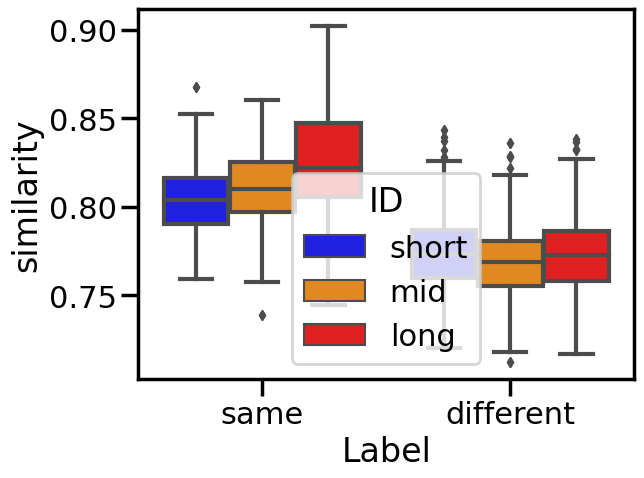

In [255]:
g = sns.boxplot(data = df_fil, x = 'Label', y = 'similarity', hue = 'ID', palette = ['blue', 'darkorange', 'red'])

In [272]:
lst = []
for i in df_noMid['ID']:
    lst.append(i)
df_noMid['Length'] = lst
df_noMid

,index,ID,similarity,label,length,Label,Length
0,1,short,0.808280,0,64.5,same,short
1,2,short,0.838083,0,51.0,same,short
2,3,short,0.831808,0,62.0,same,short
3,4,short,0.850331,0,57.0,same,short
4,5,short,0.786642,1,58.5,different,short
...,...,...,...,...,...,...,...
2375,3669,long,0.795849,1,369.0,different,long
2376,3670,long,0.810224,0,427.5,same,long
2377,3671,long,0.752015,0,411.0,same,long
2378,3672,long,0.838388,0,400.5,same,long


,index,ID,similarity,label,length,Label
0,1,short,0.808280,0,64.5,same
1,2,short,0.838083,0,51.0,same
2,3,short,0.831808,0,62.0,same
3,4,short,0.850331,0,57.0,same
4,5,short,0.786642,1,58.5,different
...,...,...,...,...,...,...
2375,3669,long,0.795849,1,369.0,different
2376,3670,long,0.810224,0,427.5,same
2377,3671,long,0.752015,0,411.0,same
2378,3672,long,0.838388,0,400.5,same


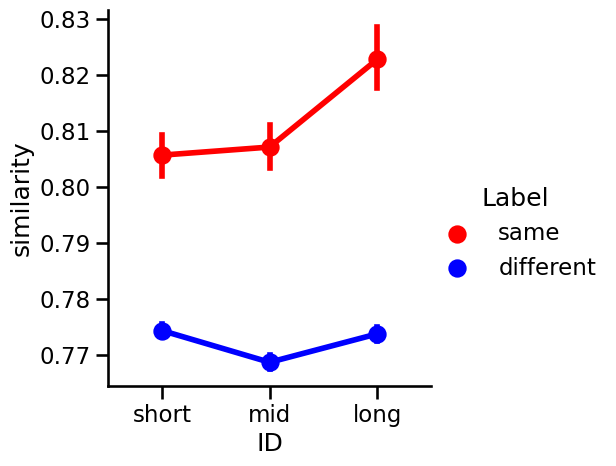

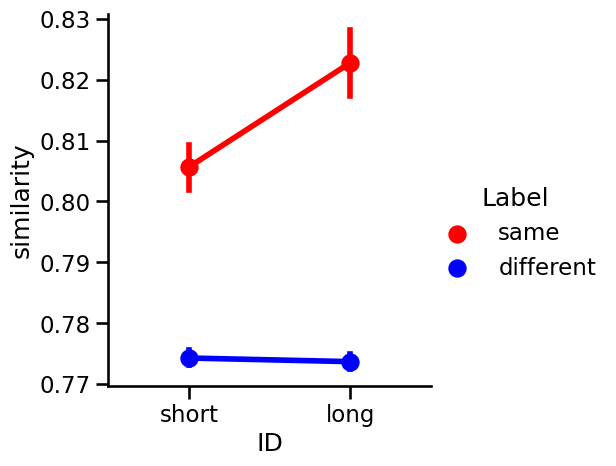

In [291]:
sns.set_context('talk')
df_noMid = df_fil[df_fil['ID'] != 'mid']
df_noMid = df_noMid.reset_index()
g = sns.catplot(data = df_fil, x = 'ID', y = 'similarity', hue = 'Label', kind = 'point',palette = ['red', 'blue'])
g = sns.catplot(data = df_noMid, x = 'ID', y = 'similarity', hue = 'Label', kind = 'point',palette = ['red', 'blue'])
df_noMid

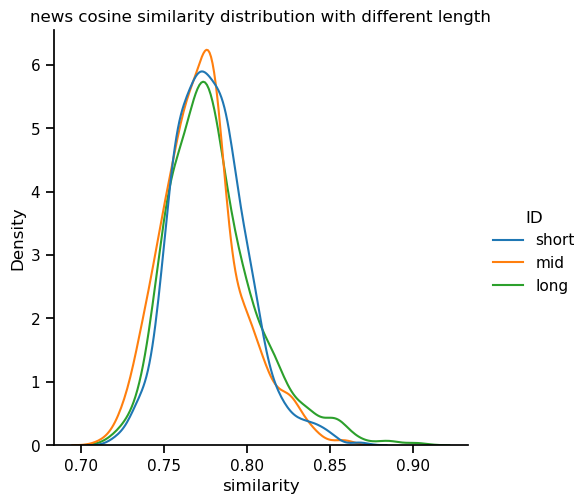

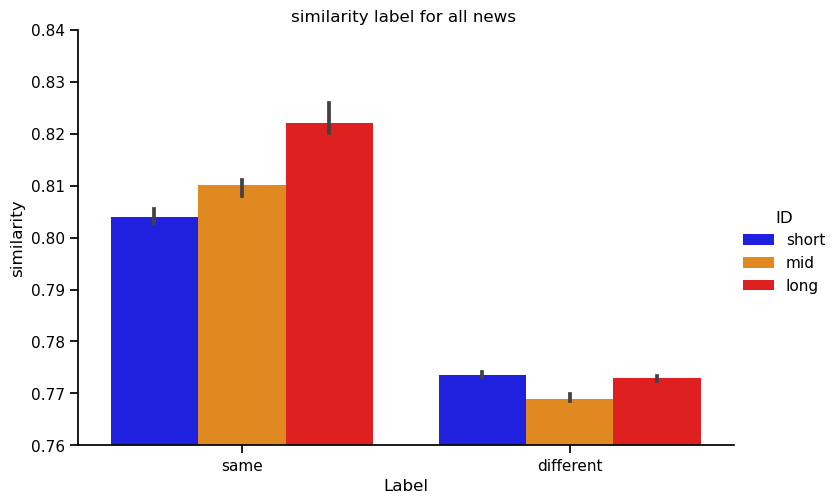

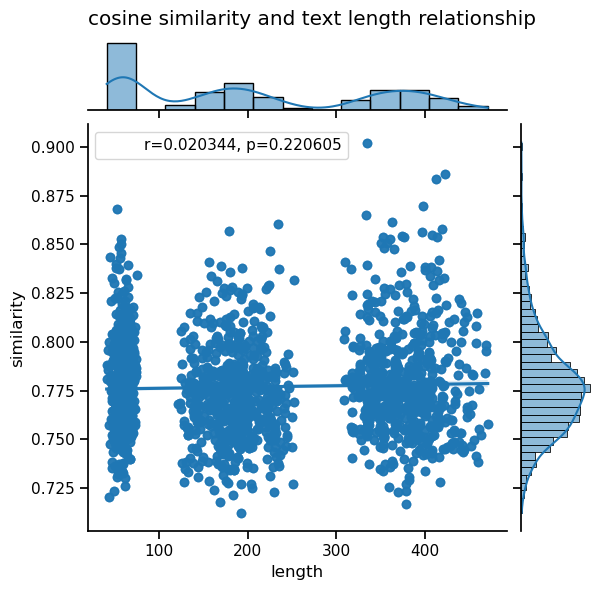

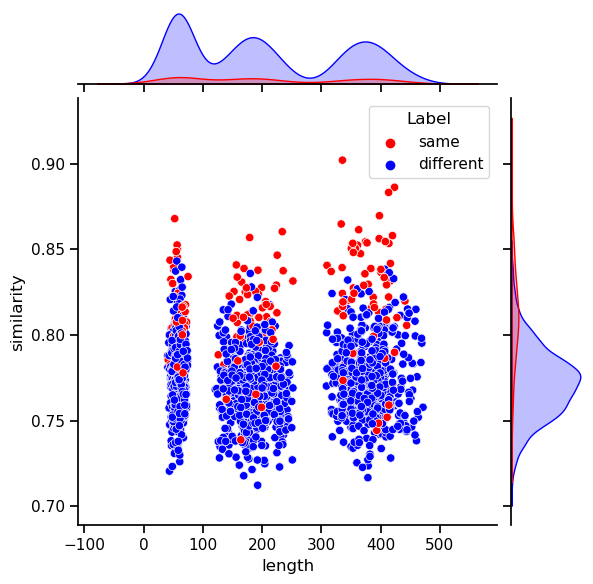

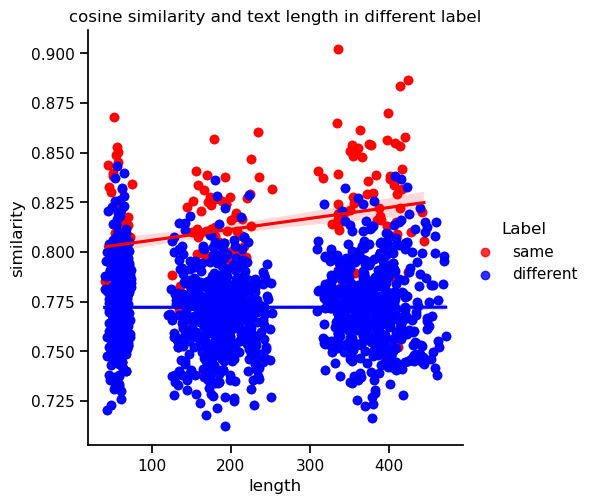

In [282]:
sns.set_context('notebook')
g = sns.displot(data = df_fil, x="similarity", hue = 'ID' , kind = 'kde')
g.set(title = 'news cosine similarity distribution with different length')
g = sns.catplot(data = df_fil, x = 'Label', y = 'similarity', hue = 'ID', errorbar=('ci', 68), kind = 'bar', aspect = 1.5, estimator = np.median, palette = ['blue', 'darkorange', 'red'])
g.set(title = 'similarity label for all news ', ylim =(0.76, 0.84) )
import scipy.stats as stats

graph = sns.jointplot(data = df_fil, x = 'length', y = 'similarity', kind = 'reg')
r, p = stats.pearsonr(df_all['length'], df_all['similarity'])

phantom, = graph.ax_joint.plot([], [], linestyle="", alpha=0)
graph.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])
graph.fig.suptitle("cosine similarity and text length relationship")
graph.fig.subplots_adjust(top=0.93)

g = sns.jointplot(data = df_fil,x = 'length', y = 'similarity', hue = 'Label', palette = ['red', 'blue'])

g = sns.lmplot(data = df_fil, x = 'length', y = 'similarity', hue = 'Label', palette = ['red', 'blue'])
g.set(title = 'cosine similarity and text length in different label')

In [140]:
df_all.to_csv('different news length similarity test.csv', index = None)

## graph only same topic cosine similarity
進一步測試是否在主題相同的文本之間，相似度隨著文本字數增加

In [134]:
df_high_sim = df_all[df_all['label'] == 0]
df_high_sim

,ID,similarity,label,length
0,short,0.808513,0,64.5
1,short,0.838177,0,51.0
2,short,0.831964,0,62.0
3,short,0.850334,0,57.0
34,short,0.808513,0,64.5
...,...,...,...,...
3535,long,0.759059,0,414.0
3566,long,0.809741,0,427.5
3567,long,0.752061,0,411.0
3568,long,0.838524,0,400.5


0.26656224363219316 2.9010680115695567e-08


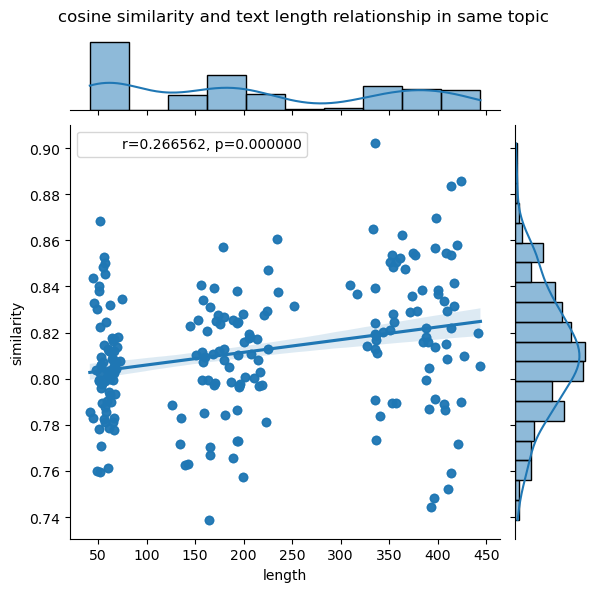

In [138]:
graph = sns.jointplot(data = df_high_sim, x = 'length', y = 'similarity', kind = 'reg')
r, p = stats.pearsonr(df_high_sim['length'], df_high_sim['similarity'])
print(r, p)

phantom, = graph.ax_joint.plot([], [], linestyle="", alpha=0)
graph.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])
graph.fig.suptitle("cosine similarity and text length relationship in same topic")
graph.fig.subplots_adjust(top=0.93)


## Merge short, middle, long news to a single dataset

In [241]:
all_embedding = embeds_s + embeds_m + embeds_l
key = []
key += ['short']* len(embeds_s) + ['middle']* len(embeds_m) + ['long']* len(embeds_l)

categories = []
cate = ['體育']*5 + ['金融']*5 + ['政治']*5 + ['美妝']*5 + ['醫學']*5 + ['藝術']*5 + ['科學']*5
categories = cate + cate + cate

len(categories)

105

In [245]:
labels = []

for i in key:
    for j in key:
        if i == j:
            labels.append(i)
        if i != j:
            if (i == 'short' and j == 'middle') or (j == 'short' and i == 'middle'):
                labels.append('short*middle')
            elif (i == 'short' and j == 'long') or (j == 'short' and i == 'long'):
                labels.append('short*long')
            elif (i == 'middle' and j == 'long') or (j == 'middle' and i == 'long'):
                labels.append('middle*long')

cate = []
for i in categories:
    for j in categories:
        if i == j:
            cate.append(0)
        else:
            cate.append(1)
len(cate)

11025

In [246]:
df_all = pd.DataFrame()

similarity_matrix = cosine_similarity(all_embedding)
df_all['similarity'] = similarity_matrix.flatten()
df_all['size'] = labels
df_all['labels'] = cate

In [236]:
df_all

,similarity,size
0,1.000000,short
1,0.808500,short
2,0.838177,short
3,0.831882,short
4,0.850334,short
...,...,...
11020,0.810341,long
11021,0.752048,long
11022,0.838677,long
11023,0.759154,long


In [239]:
# 篩選出labels為0的列並計算次數
label_s_count = df_all[df_all['size'] == 'short']['size'].value_counts()

# 篩選出labels為1的列並計算次數
label_l_count = df_all[df_all['size'] == 'long']['size'].value_counts()

print('label s count:', label_0_count)
print('label l count:', label_1_count)

label s count: 0    175
Name: label, dtype: int64
label l count: 1    1050
Name: label, dtype: int64


[Text(0.5, 1.0, 'Heatmap for long news')]

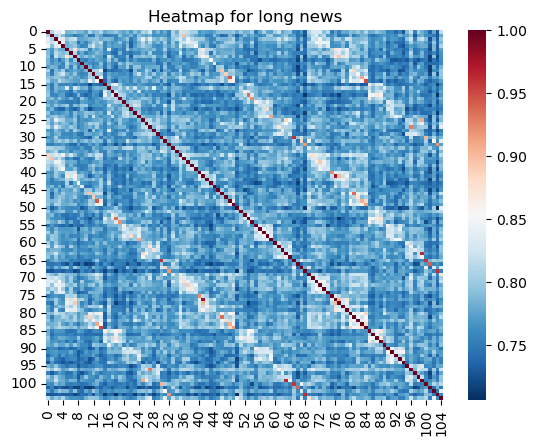

In [222]:


g = sns.heatmap(similarity_matrix, cmap="RdBu_r")
g.set(title = 'Heatmap for long news')

In [200]:
cosine_similarity(all_embedding)

array([[1.        , 0.80850014, 0.83817659, ..., 0.77583769, 0.72816111,
        0.81644974],
       [0.80850014, 1.        , 0.80588588, ..., 0.7497096 , 0.72934808,
        0.77941363],
       [0.83817659, 0.80588588, 1.        , ..., 0.77877026, 0.73245831,
        0.79710747],
       ...,
       [0.77583769, 0.7497096 , 0.77877026, ..., 1.        , 0.74837741,
        0.83867705],
       [0.72816111, 0.72934808, 0.73245831, ..., 0.74837741, 1.        ,
        0.75915365],
       [0.81644974, 0.77941363, 0.79710747, ..., 0.83867705, 0.75915365,
        1.        ]])

In [201]:
cosine_similarity(all_embedding).flatten()

array([1.        , 0.80850014, 0.83817659, ..., 0.83867705, 0.75915365,
       1.        ])

[Text(0.5, 1.0, 'Heatmap for long news')]

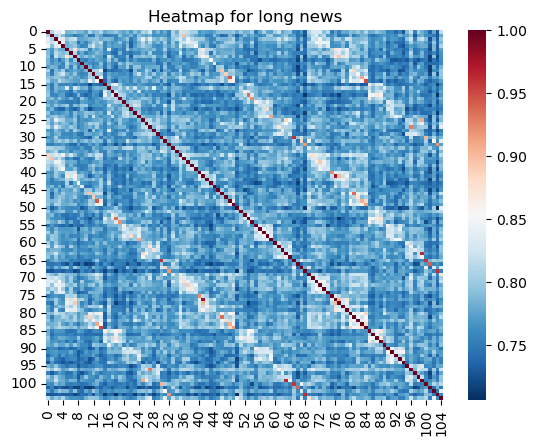

In [193]:
g = sns.heatmap(similarity_matrix, cmap="RdBu_r")
g.set(title = 'Heatmap for long news')

In [198]:
for i in labels:
    print(i)

short
short
short
short
short
short
short
short
short
short
short
short
short
short
short
short
short
short
short
short
short
short
short
short
short
short
short
short
short
short
short
short
short
short
short
short*middle
short*middle
short*middle
short*middle
short*middle
short*middle
short*middle
short*middle
short*middle
short*middle
short*middle
short*middle
short*middle
short*middle
short*middle
short*middle
short*middle
short*middle
short*middle
short*middle
short*middle
short*middle
short*middle
short*middle
short*middle
short*middle
short*middle
short*middle
short*middle
short*middle
short*middle
short*middle
short*middle
short*middle
short*middle
short*long
short*long
short*long
short*long
short*long
short*long
short*long
short*long
short*long
short*long
short*long
short*long
short*long
short*long
short*long
short*long
short*long
short*long
short*long
short*long
short*long
short*long
short*long
short*long
short*long
short*long
short*long
short*long
short*long
short*long
short

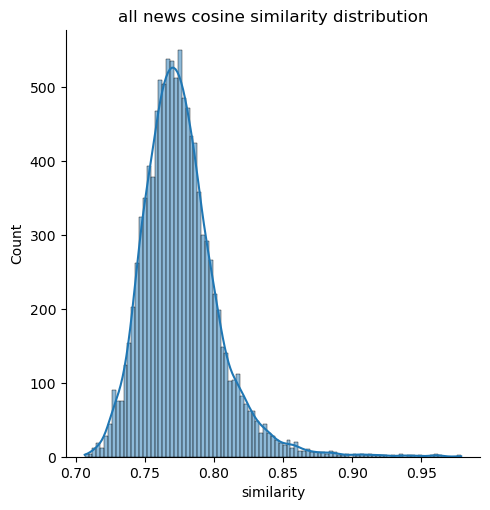

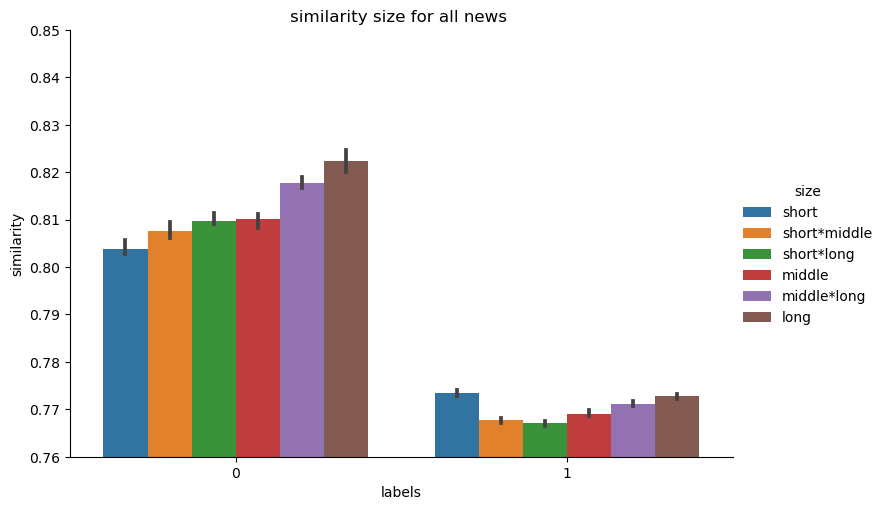

In [250]:
df_all = df_all.drop(df_all[df_all['similarity'] > 0.9999].index)
g = sns.displot(data=df_all, x="similarity", kde=True)
g.set(title = 'all news cosine similarity distribution')
g = sns.catplot(data = df_all, x = 'labels', y = 'similarity', hue = 'size',  errorbar=('ci', 68), kind = 'bar', aspect = 1.5, estimator = np.median) #palette = ['blue', 'darkorange'])
g.set(title = 'similarity size for all news ', ylim =(0.76, 0.85) )#
import scipy.stats as stats

#graph = sns.jointplot(data = df_all, x = 'length', y = 'similarity', kind = 'reg')
#r, p = stats.pearsonr(df_long['length'], df_long['similarity'])

#phantom, = graph.ax_joint.plot([], [], linestyle="", alpha=0)
#graph.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])
#graph.fig.suptitle("cosine similarity and text length relationship")
#graph.fig.subplots_adjust(top=0.93)
